<a href="https://colab.research.google.com/github/lunadacosta/Master-Thesis/blob/master/First_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Base Model

Created by: Luciana G. Da Costa

On this notebook I will explanate on the building of a basic sequential neural network for classification of messages replies obtained from Rspamd.

# Dataset

The E-mails used here where freely obtained from the: *insert the name of the website and a url*

This dataset is very helpful, because they already separate SPAM from HAM. Next step was to pass those E-mails through Rspamd, so we could collect the symbols resulting from the checking that Rspamd peform on them.

Mounting google drive to access the datasets


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now we read the datasets with pandas. We have two .csv files with about 1000 rows and two colums. First column is a string with all symbols related to one message. Second column is the label: 0= ham and 1= spam. I also add another column to the dataframe that pandas will create, this column ('source') will point from which -csv file the input originates.

After readed, the files are concatenate and then shuffled. Bellow one can see the first then rows of the dataframe.

In [0]:
import pandas as pd

##### Load data with Pandas ######

filepath_dict = {'spam': 'gdrive/My Drive/Colab Notebooks/dataset/spam.csv',
                 'ham': 'gdrive/My Drive/Colab Notebooks/dataset/ham.csv'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['symbols', 'label'], sep=';')
    df['source'] = source  #Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
##### label=0: ham, label=1_ spam #################
print(df.iloc[0:10,:])

## randomize dataset, not really used, was just for learning purpose
frame = df.sample(frac=1).reset_index(drop=True)
print(frame.iloc[0:10,:])

                                             symbols  label source
0               ARC_NA              DATE_IN_PAST ...      1   spam
1               ARC_NA              DATE_IN_PAST ...      1   spam
2               ARC_NA              FROM_HAS_DN  ...      1   spam
3               ARC_NA              FROM_NEQ_DISP...      1   spam
4               ARC_NA              R_SPF_DNSFAIL...      1   spam
5               ARC_NA              SUBJ_EXCESS_B...      1   spam
6               ARC_NA              R_SPF_DNSFAIL...      1   spam
7               ARC_NA              SUBJECT_ENDS_...      1   spam
8               ARC_NA              FROM_HAS_DN  ...      1   spam
9               ARC_NA              DATE_IN_PAST ...      1   spam
                                             symbols  label source
0               ARC_NA              R_SPF_DNSFAIL...      1   spam
1               ARC_NA              CTE_CASE     ...      1   spam
2               ARC_NA              MV_CASE      ...      0   

I now split my dataframe between train dataset and test dataset on a proportion 75/25. Still I need to prep-process this dataset, so that the NN can peform calculations on it. So there is a need to convert the symbols into non-identical numbers. On this case I chose a tool from Scikit called CountVectorizer to tokenize my document and create a "vocabulary" index from it.

In [0]:
############### split the dataset in train and test dataset ##############

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

for source in frame['source'].unique():
    df_source = frame[frame['source'] == source]
    sentences = df_source['symbols'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)
    
    #print(sentences_train)
    
##### Tokenize using CountVectorizer#######

    vectorizer = CountVectorizer()
    # building the vocabulary
    vectorizer.fit(sentences_train)
    vocab = vectorizer.vocabulary_
    print(vocab)
    # vectorize the documents with the vocabulary
    X_train = vectorizer.transform(sentences_train)
    X_test = vectorizer.transform(sentences_test)
    print(X_train)


{'arc_na': 0, 'r_spf_dnsfail': 106, 'from_has_dn': 33, 'freemail_from': 26, 'html_short_link_img_1': 60, 'mime_good': 81, 'mime_trace': 86, 'to_dn_none': 156, 'uri_count_odd': 163, 'rcpt_count_one': 113, 'rcvd_count_three': 122, 'dmarc_dnsfail': 10, 'rcvd_no_tls_last': 129, 'from_eq_envfrom': 30, 'r_dkim_na': 101, 'freemail_envfrom': 24, 'date_in_past': 6, 'hfilter_hostname_unknown': 56, 'received_spamhaus_fail': 133, 'mime_ma_missing_html': 84, 'to_dn_all': 154, 'mid_contains_from': 73, 'subject_ends_spaces': 147, 'subj_excess_base64': 143, 'previously_delivered': 99, 'r_parts_differ': 105, 'invalid_postfix_received': 67, 'has_x_prio_three': 49, 'phishing': 97, 'mid_rhs_match_from': 76, 'has_replyto': 45, 'rcvd_count_five': 119, 'replyto_eq_from': 138, 'precedence_bulk': 98, 'cte_case': 4, 'tagged_from': 153, 'from_neq_envfrom': 38, 'subj_all_caps': 142, 'subject_ends_exclaim': 145, 'mid_rhs_not_fqdn': 78, 'to_eq_from': 159, 'r_empty_image': 102, 'missing_mid': 89, 'ctype_mixed_bogus'

***Here we have a strange behaviour. For some reason, in Colab Notebook, the Count Vectorizer is creating two distinct vocabulary. Also the vectorization has assume an strange format, which is probably affecting the training of the NN***

I want to build a simple two layers Keras sequential model. As input dimension for the first layer we have the shape of the X_train set. As loss function we use Binary Cross Entropy, which is really good option for classification problems, and Adam will be the Optimizer.

In [0]:
####### here starts the keras_model #######
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Numbers of features

model = Sequential()
model.add(layers.Dense(200, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#TensorFlow as backend

### configuration of the learning process ###

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()  # gives an overview of the model

###### training with the .fit() function #######

history = model.fit(X_train, y_train, epochs=5, verbose=False, validation_data=(X_test, y_test), batch_size=20)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               33200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 33,401
Trainable params: 33,401
Non-trainable params: 0
_________________________________________________________________


For now as metric for evaluation of our NN we are using accuracy.

In [0]:
##### .evaluate() is used to measure the accuracy of the model ########

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy:  1.0000
Testing Accuracy:  1.0000


To help us vizualizate how the accuracy and the loss of the training and dataset are going we can plot this graphic.

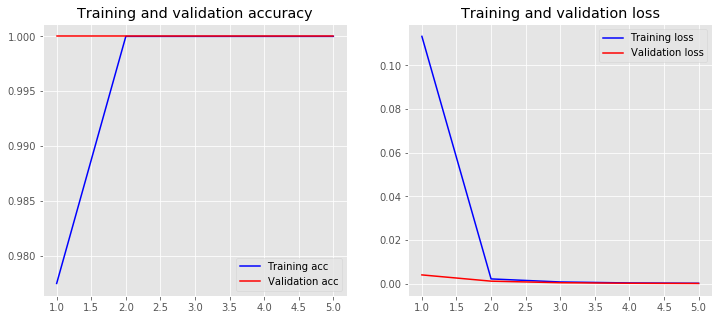

In [0]:
####### Visualization of the loss an the accuracy for the training and testing data set ############
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()